In [1]:
import perceval as pcvl
from perceval.algorithm import Sampler
from math import pi
from perceval.components import BS, PS
import numpy as np

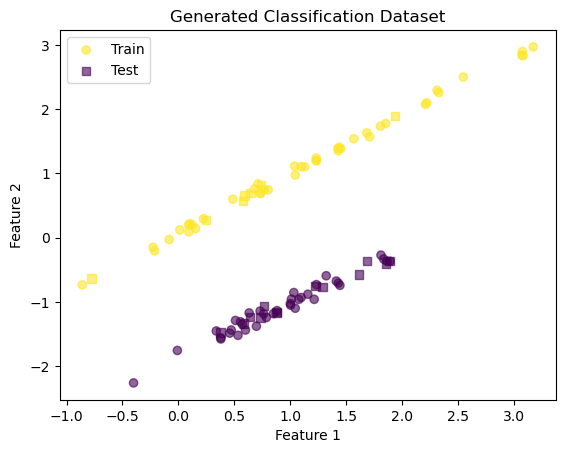

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Generate dataset with 2 features
X, y = make_classification(n_samples=100, n_features=2, n_classes=2, n_clusters_per_class=1, n_redundant = 0,random_state=42)

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot the dataset
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o', label="Train", alpha=0.6)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='s', label="Test", alpha=0.6)
plt.legend()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated Classification Dataset")
plt.show()


In [3]:
#KLM CNOT

def fock_states(n, m):
    """Return a list of lists corresponding to all Fock states with
    n photons in m modes, ordered in descending lexicographic order."""
    if m == 1:
        return [[n]]
    states = []
    # Iterate i from n down to 0 to ensure descending order in the first mode
    for i in range(n, -1, -1):
        for tail in fock_states(n - i, m - 1):
            states.append([i] + tail)
    return states


state_00 = pcvl.BasicState([1, 0, 1, 0])
state_01 = pcvl.BasicState([1, 0, 0, 1])
state_10 = pcvl.BasicState([0, 1, 1, 0])
state_11 = pcvl.BasicState([0, 1, 0, 1])
state_matrix = np.array([np.array(state_00), np.array(state_01),np.array(state_10), np.array(state_11)])

states = np.array(fock_states(10, 20))
result = states[:,:4] @ state_matrix
max_indices = result.argmax(1)
indices_to_use = np.where(max_indices % 2 == 1)[0]
indices_to_use.shape

(7800820,)

In [4]:
import time
CNOT = pcvl.catalog["klm cnot"].build_processor()
depth = 2

def phaseGate(param):
    return pcvl.Circuit(2).add(1, PS(param))
theta = [pcvl.P(f"theta{i}") for i in range(depth * 3)]
x = [pcvl.P(f"x{i}") for i in range(3)]

feature_map = pcvl.Processor(pcvl.SLOSBackend(),4)
ansatz = pcvl.Processor(pcvl.SLOSBackend(),4)


for i in range(2*depth + 1):
    if i % 2 == 0:
        ansatz.add(0, BS.Ry(theta = theta[i]))
        ansatz.add(2, BS.Ry(theta = theta[i + 1])) 
    else:
        ansatz.add(0,CNOT)

feature_map.add(0, BS.H())
feature_map.add(2, BS.H())
feature_map.add(0, phaseGate(x[0]))
feature_map.add(2, phaseGate(x[1]))
feature_map.add(0, CNOT)
feature_map.add(2, phaseGate(x[2]))
feature_map.add(0, CNOT)

vqc = pcvl.Processor(pcvl.SLOSBackend(), 4)
vqc.add(0, feature_map)
vqc.add(0, ansatz)

backend = pcvl.SLOSBackend()
vqc_params = vqc.get_circuit_parameters()
def_input = pcvl.BasicState([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

def probs_to_predictions(probs):
    return np.sum(probs[indices_to_use])
def get_prediction(data, num_samples):
    vqc_params["x0"].set_value(2*data[0])
    vqc_params["x1"].set_value(2*data[1])
    vqc_params["x2"].set_value(2*(pi - data[0])*(pi - data[1]))

    vqc_circ = vqc.linear_circuit()
    backend.set_circuit(vqc_circ)
    backend.set_input_state(def_input)
    time1 = time.time_ns() 
    probs = np.array(backend.all_prob())
    time2 = time.time_ns()
    prediction = probs_to_predictions(probs)
    time3 = time.time_ns()
    print(time2 - time1)
    print(time3 - time2)
    return prediction

def loss(params, data = X_train, target = y_train, num_samples = 10):
    pred_arr = np.zeros(shape = (data.shape[0]))
    for i in range(len(params)):
        vqc_params[f"theta{i}"].set_value(params[i])
    for i in range(data.shape[0]):
        pred_arr[i] = get_prediction(data[i], num_samples)
    np.clip(pred_arr,1e-8,1 - 1e-8)
    loss = -np.mean(target*np.log2(pred_arr) + (1 - target)*np.log2(1 - pred_arr))
    return loss

In [5]:
from scipy.optimize import minimize, OptimizeResult

init_params = np.random.default_rng(42).random(size = (depth*3))

klm_arr = []

def callback(intermediate_result: OptimizeResult):
    klm_arr.append(intermediate_result.fun)
    print(intermediate_result.fun)

res = minimize(loss, init_params, args = (X_train, y_train), method = "L-BFGS-B", callback = callback)

2972153900
31267700
2825237600
31272400
2824599400
37090400
2829867000
31586800
2920613000
31258900
2825583200
31540300
2834298200
31698500
2834807200
26268000
2811922300
29555700
2808674500
31365600
2820574000
27657300
2827825500
31306100
2837419200
21234600
2836025600
26786900
2767135900
28984500
2767302800
27159900
2759996300
27870400
2768417200
33795300
2842269200
20602800
2830148700
31568300
2893172700
31525300
2799641100
15942100
2815273100
28562100
2884741000
27784800
2841381700
31538400
2827489200
31410800
2948649600
28426100
2861413800
20061600
2853107300
30862900
2851412800
31676500
2854042200
30754000
2951966900
27196700
2895906900
16058800
2827487200
31327600
2832359100
25712400
2823874600
28087000
2872546100
24271900
2920639600
25742600
2825838000
31312400
2831956100
31931900
2937378700
31274800
2831282700
15637700
2826790700
15637800
2820641100
31664500
2817038100
35112900
2846585100
31332200
2828292500
37402100
2840412300
27563600
2863164300
31537300
2844578700
41722900


In [7]:
# Function to calculate accuracy
def calculate_accuracy(params, x_data, y_true):
    # Get predictions using the trained model
    predictions = np.zeros(shape = (x_data.shape[0]))
    for i in range(len(params)):
        vqc_params[f'theta{i}'].set_value(params[i])
    for i in range(x_data.shape[0]):
        predictions[i] = get_prediction(x_data[i],1)
    predicted_labels = (predictions >= 0.5).astype(int)
    print(predictions)
    print(predicted_labels)
    # Calculate accuracy
    accuracy = np.mean(predicted_labels == y_true)
    return accuracy
opt_params = res.x
# Calculate training accuracy
train_accuracy = calculate_accuracy(opt_params, X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Calculate testing accuracy
test_accuracy = calculate_accuracy(opt_params, X_test, y_test)
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(y_test)


2834186200
132951600
2937945400
28637700
2951360700
30855700
2823505100
39373200
2839252800
20047300
2841177400
15728200
2881272200
15718200
2851540400
23896400
2806954600
19473100
2830437700
31409700
2795689500
27032400
2808967400
31275300
2792389200
31168000
2802165700
32190900
2571666000
31528700
2822198700
15633100
2811762000
36625600
2781754400
27114400
2832179100
26407800
2805949200
26799500
2793093100
31727700
2822214700
31571900
2811404200
26207900
2817054200
31741600
2808824000
27865300
2799555100
26905900
2804115000
31271900
2817377200
15914500
2824622500
25586600
2786566100
31695000
2796194900
26067600
2831392100
20055600
2822253100
31628300
2803430700
15630400
2801640400
38920800
2814576300
20780800
2838746500
15634700
2835618800
31563100
2858293400
15151800
2866856400
16034200
2835897400
22917100
2829865100
31267700
2857975800
33370600
2811942800
25907700
2874413800
15953200
2821199600
31474100
2829863200
34529100
2835626100
31629300
2810803500
29692200
2840458500
15633600